In [1]:
!pip uninstall pyfolio  # 卸载
!pip install git+https://github.com/quantopian/pyfolio 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-rip7sgml
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-rip7sgml
     |████████████████████████████████| 52 kB 1.2 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75774 sha256=73a3c2868609d89f8171edf5dceb2aec3d3c989f04caf1e6c4e21e32b770c67a
  Stored in directory: /tmp/pip-ephem-wheel-cache-wrwb1iao/wheels/2d/aa/24/c99ed55ef37c69e33815248c1622cdb81b65ec753868004c28
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39780 sha256=ce7ce833f0beb8328c8c54c9febab548382fe574785dd51ee6c5508832f77ec8
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical


In [ ]:
!pip install empyrical

In [ ]:
import pyfolio as pf

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Mounted at /content/drive


### Read Data

In [ ]:
data_file = '/content/drive/MyDrive/capstone-pimco/Part1/'
path = data_file+'time_series_analysis/index_data/'
index_paths = os.listdir(path)

# Index data
index_paths

['U.S. Government:Credit.csv',
 'U.S. Aggregate.csv',
 'S&P 500.csv',
 'U.S. Issued High Yield.csv',
 'Nasdaq 100.csv',
 'Russell 2000.csv',
 'U.S. Issued Investment Grade.csv',
 'KBW Bank.csv',
 'Mortgage-Backed.csv',
 'Bitcoin.csv',
 'KBW Bank ETF.csv',
 'MSCI Emerging Markets Index.csv',
 'CPI.csv',
 'Vanguard Real Estate Index Fund.csv',
 'FMCC.csv',
 'FNMA.csv',
 'GNMA.csv',
 'CPI Historical Data.csv',
 'Bloomberg Commodity.csv',
 'Crude Oil WTI Futures.csv',
 'Gold Futures.csv',
 'US Corn Futures.csv',
 'US Wheat Futures.csv']

In [ ]:
# Directionality prediction
df = pd.read_csv('/content/drive/MyDrive/capstone-pimco/Part1/data/distance_base/direction_stem/fbp/dist_base_test.csv', index_col=0)

In [ ]:
topics = df['predicted_topics_is_growth'].unique()
indices = [index_path[:-4] for index_path in index_paths]

Below are all the indices and topics we have.

In [ ]:
indices

['U.S. Government:Credit',
 'U.S. Aggregate',
 'S&P 500',
 'U.S. Issued High Yield',
 'Nasdaq 100',
 'Russell 2000',
 'U.S. Issued Investment Grade',
 'KBW Bank',
 'Mortgage-Backed',
 'Bitcoin',
 'KBW Bank ETF',
 'MSCI Emerging Markets Index',
 'CPI',
 'Vanguard Real Estate Index Fund',
 'FMCC',
 'FNMA',
 'GNMA',
 'CPI Historical Data',
 'Bloomberg Commodity',
 'Crude Oil WTI Futures',
 'Gold Futures',
 'US Corn Futures',
 'US Wheat Futures']

In [ ]:
topics

array(['fed funds rate', 'labor market', 'growth', 'inflation', 'housing',
       'financial markets', 'credit', 'quantitative easing',
       'liquidity measures', 'geopolitical uncertainty'], dtype=object)

### Backtesting Function

For each positive direction signal, we open one long position and close it after holding_period days and for each negative direction signal we open one short position and close it after holding_period days. Holding_period is 1 for daily time horizon, 21 for monthly time horizon and 252 for yearly time horizon.

In [ ]:
import empyrical
from collections import OrderedDict
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pyfolio as pf
from scipy.stats import gmean

END_DATE = datetime.now().date()
class Port_Backtesting():

    '''
    -----------Attributes-----------

    self.start_date: start date of the backtesting period

    self.end_date: end date of the backtesting period

    self.holding_period: number of days holding the position

    self.price_signal_df: dataframe storing: daily price of the given index	
                          predicted directionality (in float)
                          predicted signal (-1, 0 or 1)
                          position (aggregated positions of all transactions if time horizon is week, month or year)
                          percentage return (return of the directionality strategy). 
                                **NOTE** The return of a given period is stored at the date of closing the position. 
                          benchmark return (return of simply buy and hold strategy)
                          benchmark return in the same period (always go long)

    self.ret_sr: daily return from self.start_date to self.end_date
            for self.holding_period > 1, daily return is divided by the holding period:
                (price in the end of the holding period - price in the start of the holding period) / 
                (price in the start of the holding period * holding period)

    self.benchmark_ret_sr: daily return of simply buy and hold strategy

    '''

    def __init__(self, df, time_span=6, end_date=END_DATE):

        '''
        time_span: Int. The time scale we are looking into. The function will 
              evaluate the model performance from [time_span] years ago to now. 
              For example, if the time span is 6 and today is 05/01/2022, 
              then we are looking into the return from 05/01/2016 to now.
        end_date: In datetime.date format. The default end_date is today. If you assign 
              a different end_date, then the function will calculate the return 
              from [time_span] years before end_date to end_date.
        '''
        
        self.df = df
        self.start_date = (end_date - relativedelta(years=time_span))
        self.end_date = end_date

    def eval_ret(self):

        '''
        -----------Output-----------
        A dictionary showing the annual_return, sharpe_ratio, max_drawdown of the directionaltiy strategy and benchmark (buy and hold).

        '''
        res = OrderedDict()
        res['annual_return'] = round(empyrical.annual_return(self.ret_sr), 4)
        res['benchmark_annual_return'] = round(empyrical.annual_return(self.benchmark_ret_sr), 4)
        res['sharpe_ratio'] = round(empyrical.sharpe_ratio(self.ret_sr), 4)
        res['benchmark_sharpe_ratio'] = round(empyrical.sharpe_ratio(self.benchmark_ret_sr), 4)
        res['max_drawdown'] = round(empyrical.max_drawdown(self.ret_sr), 4)
        res['benchmark_max_drawdown'] = round(empyrical.max_drawdown(self.benchmark_ret_sr), 4)
        return res

    def eval_ret_multiple_holding_days(self):
        
        '''
        -----------Output-----------
        A dictionary showing the annual_return, sharpe_ratio, max_drawdown of the directionaltiy strategy and benchmark (buy and hold).
        For holding period large than 1, since there are overlaps between different hold periods, we calculate the mean annual return,
        sharpe ratio and max drawdown instead of simply accumulate the return.

        '''
        res = OrderedDict()
        self.annual_returns = []
        self.sharpe_ratios = []
        self.max_drawdowns = []

        # for each transaction (opening a position at day a and closing it at day a + holding_period)
        # calculate the annual return, sharpe ratio and max drawdown
        for date in self.price_signal_df.index:
            signal = self.price_signal_df.loc[date, 'signal']
            if signal == 0:
                continue
            ret_in_holding_period = (self.price_signal_df.loc[date:, 'Close'][:self.holding_period+1].pct_change().dropna())*signal
            if len(ret_in_holding_period) < self.holding_period:
                continue
            self.annual_returns.append(empyrical.annual_return(ret_in_holding_period))
            self.sharpe_ratios.append(empyrical.sharpe_ratio(ret_in_holding_period))
            self.max_drawdowns.append(empyrical.max_drawdown(ret_in_holding_period))
        res['annual_return'] = round(np.mean(self.annual_returns), 4)
        res['benchmark_annual_return'] = round(empyrical.annual_return(self.benchmark_ret_sr), 4)
        res['sharpe_ratio'] = round(np.mean(self.sharpe_ratios), 4)
        res['benchmark_sharpe_ratio'] = round(empyrical.sharpe_ratio(self.benchmark_ret_sr), 4)
        res['max_drawdown'] = round(np.mean(self.max_drawdowns), 4)
        res['benchmark_max_drawdown'] = round(empyrical.max_drawdown(self.benchmark_ret_sr), 4)

        return res

    def _str2float(self, x): 
        # Convert close prices to float format.
        if type(x) == type('a'):
            x = x.replace(',', '')
            return float(x)
        else:
            return x


    def evaluate(self, topic, index, time_horizon, aggregate_method='sum'):

        '''
        -----------Input-----------
        topic: should be chosen from ['fed funds rate', 'labor market', 'growth', 'inflation', 
            'housing', 'financial markets', 'credit', 'quantitative easing',
            'liquidity measures', 'geopolitical uncertainty']

        index: should be chosen from ['U.S. Government:Credit', 'U.S. Aggregate', 'S&P 500', 
            'U.S. Issued High Yield', 'Nasdaq 100', 'Russell 2000', 'U.S. Issued Investment Grade',
            'KBW Bank', 'Mortgage-Backed', 'Bitcoin', 'KBW Bank ETF', 'MSCI Emerging Markets Index',
            'CPI', 'Vanguard Real Estate Index Fund', 'FMCC', 'FNMA', 'GNMA', 'CPI Historical Data', 
            'Bloomberg Commodity', 'Crude Oil WTI Futures', 'Gold Futures', 'US Corn Futures', 'US Wheat Futures']

        time_horizon: How long to hold the position. 
               Can be: 'day', 'month' and 'year'.

        aggregate_method: How to aggregate multiple directionality signals on the same day. 
                  Can be: 'sum', 'median', 'mean'


        -----------Output-----------
        A dictionary showing the annual_return, sharpe_ratio, max_drawdown of the directionaltiy strategy and benchmark (buy and hold).
        
        '''
        self.annual_returns = []
        self.sharpe_ratios = []
        self.max_drawdowns = []
        self.benchmark_annual_returns = []
        self.benchmark_sharpe_ratios = []
        self.benchmark_max_drawdowns = []

        # topic directionality df
        df_ = self.df[self.df['predicted_topics_is_growth'] == topic]
        topic_df = pd.DataFrame(df_.groupby('date')['pred_distance_fbp'].agg(aggregate_method), columns=['pred_distance_fbp'])
        topic_df.index = pd.to_datetime(topic_df.index)
        topic_df['signal'] = np.sign(topic_df['pred_distance_fbp'])

        # index price df
        index_path = index + '.csv'
        index_df = pd.read_csv(path+index_path)
        # assign col name for different data format
        col = ''
        if 'Close' in index_df.columns:
            col = 'Close'
        elif 'Price' in index_df.columns:
            col = 'Price'
        #continue
        # date format
        index_df['Date']  = pd.to_datetime(pd.to_datetime(index_df['Date']).dt.strftime('%Y%m%d'))
        # select columns
        index_df = index_df[['Date',col]]
        # rename to a uniform name
        index_df = index_df.rename(columns={col:'Close'})

        # transformation from str to float
        index_df['Close'] = index_df['Close'].map(self._str2float)
        # sort by date
        index_df = index_df.sort_values(by=['Date'], ignore_index=True)
        index_df = index_df.set_index("Date")

        # join price and directionality 

        self.price_signal_df = index_df.join(topic_df, how='left')
        # if a business day does not have directionality signal, fill with signal 0.
        self.price_signal_df['signal'] = self.price_signal_df['signal'].fillna(0)

        holding_period_dict = {'day': 1, 'month': 21, 'year': 252}
        self.holding_period = holding_period_dict[time_horizon]

        self.price_signal_df = self.price_signal_df[self.start_date:self.end_date]
        #self.price_signal_df['price_diff'] = self.price_signal_df['Close'].diff().shift(-1)
        self.price_signal_df['position'] = self.price_signal_df['signal'].rolling(self.holding_period, min_periods=1).sum()

        self.price_signal_df['return'] = (self.price_signal_df['Close'].pct_change(self.holding_period).shift(-self.holding_period)*\
                                          self.price_signal_df['signal']).shift(self.holding_period)
        self.price_signal_df['benchmark_return'] = self.price_signal_df['Close'].pct_change()
        self.price_signal_df['benchmark_return_same_period'] = self.price_signal_df['Close'].pct_change(self.holding_period)

        self.ret_sr = self.price_signal_df['return'].dropna()
        self.benchmark_ret_sr = self.price_signal_df['benchmark_return'].dropna()
        if self.holding_period == 1:
            self.evaluation = self.eval_ret()
        else:
            self.evaluation = self.eval_ret_multiple_holding_days()

        return self.evaluation

    def plot_evaluation(self, topic, index, time_horizon, aggregate_method='sum'):

        '''
        -----------Input-----------

        Input is same as self.evaluate()
        This function can be called independently. You don't need to call self.evaluate() first.

        -----------Output-----------
        See pf.create_returns_tear_sheet
          **NOTE** The plots for holding_period > 1 are not so accurate since we approximate 
               the daily return by dividing return for each holding period by number of holding days.
        '''

        self.evaluate(topic, index, time_horizon, aggregate_method)
        fig = pf.create_returns_tear_sheet(self.ret_sr / self.holding_period, benchmark_rets=self.benchmark_ret_sr, return_fig=True)
        for ax in fig.axes:
                ax.tick_params(
                axis='x',           # changes apply to the x-axis
                which='both',       # both major and minor ticks are affected
                bottom=True,
                top=False,
                labelbottom=True)

### Choose the parameter of the model.

In [ ]:
aggregate_method = 'sum' # aggregate the signal by date: 'sum', 'mean', 'median'
time_horizon = 'year' # 'day', 'month', 'year'
time_span = 6 # Length of time in consideration. Number in year.

### Evaluate Strategy

Evaluate on all pairs of indices and topics.

In [ ]:
from tqdm import tqdm
eval_dfs = {}
evals = ['annual_return', 'benchmark_annual_return', 'sharpe_ratio', 'benchmark_sharpe_ratio', 'max_drawdown', 'benchmark_max_drawdown']
pb = Port_Backtesting(df, time_span)
for eval in evals:
    eval_dfs[eval] = pd.DataFrame(index=indices, columns=topics)
for index in tqdm(indices):
    for topic in topics:
        eval_res = pb.evaluate(topic, index, time_horizon, aggregate_method)
        for eval in evals:
            eval_dfs[eval].loc[index, topic] = eval_res[eval]

100%|██████████| 23/23 [02:25<00:00,  6.34s/it]


Print out the sharpe ratio of the directionality strategy

In [ ]:
eval_dfs['sharpe_ratio']

,fed funds rate,labor market,growth,inflation,housing,financial markets,credit,quantitative easing,liquidity measures,geopolitical uncertainty
U.S. Government:Credit,-0.3558,-0.0284,-1.324,0.3012,-1.0377,0.2841,-0.1795,-0.4353,0.1652,-0.0034
U.S. Aggregate,-0.4724,-0.0175,-1.2858,0.2408,-0.9932,-0.0895,0.0765,-0.0043,0.4065,-0.3838
S&P 500,-0.4388,0.7361,-0.1128,-0.3363,-0.1277,-0.5637,-0.142,0.7586,-0.0562,0.2255
U.S. Issued High Yield,-0.4882,1.4047,-0.1675,-0.5273,-0.0009,-0.2412,-0.1156,0.481,-0.1987,0.3018
Nasdaq 100,-0.1953,0.648,-0.4318,-0.0738,0.0755,-0.1973,0.1377,0.9775,0.067,0.1442
Russell 2000,-0.0715,0.9849,0.2188,-0.2691,-0.2021,-0.8093,-0.2481,0.4384,-0.1722,0.0764
U.S. Issued Investment Grade,-0.7214,0.1178,-0.8477,0.1149,-0.972,-0.5025,0.1777,0.1436,0.4118,-0.3942
KBW Bank,-0.0417,0.8713,0.8491,0.3252,-0.1754,-0.7719,-0.3316,0.4723,-0.0621,0.2025
Mortgage-Backed,-0.2763,0.251,-0.8967,-0.0375,-0.4378,0.1175,0.1399,0.3447,0.542,-0.2298
Bitcoin,0.6907,0.4934,0.4387,0.6135,0.305,0.0532,-0.0632,0.501,0.5113,-0.1345


### Select candidate pairs

Choose candidate pairs of index and topic that has sharpe ratio > 1 and also 1.5 times larger than the benchmark sharpe ratio.

In [ ]:
topic_index_pairs = []
min_trading_days = 100
for index in indices:
    for topic in topics:
        if eval_dfs['sharpe_ratio'].loc[index, topic] > 1 \
        and (eval_dfs['sharpe_ratio'].loc[index, topic] > 1 * eval_dfs['benchmark_sharpe_ratio'].loc[index, topic]) \
        and (eval_dfs['annual_return'].loc[index, topic] > 1 * eval_dfs['benchmark_annual_return'].loc[index, topic]):
            
            eval_dict = pb.evaluate(topic, index, time_horizon, aggregate_method)
            signals = pb.price_signal_df['signal'][pb.start_date:]
            returns = pb.price_signal_df['return'][pb.start_date:]
            if len(signals) - sum(signals == 0) < min_trading_days:
                continue
            print()
            print('index: ', index)
            print('topic: ',  topic)
            print('_________')
            print(f"{'number of business days: ':<40} {len(signals)}")
            print(f"{'number of tradings: ':<40} {len(signals) - sum(signals == 0)}")
            print('-----')
            print(f"{'number of long positions: ':<40} {sum(signals > 0)}")
            print(f"{'number of short positions: ':<40} {sum(signals < 0)}")
            print(f"{'average daily return of long positions: ':<40} {round(returns[signals>0].mean(), 4)}")
            print(f"{'average daily return of short positions: ':<40} {round(returns[signals<0].mean(), 4)}")
            print(f"{'average daily return of all positions: ':<40} {round(returns.mean(), 4)}")
            print('-----')
            for k, v in eval_dict.items():
                print(f"{k + ': ':<40} {v}")
            print('**************************************************')
            topic_index_pairs.append((topic, index))

### Evaluate Performance

In [ ]:
pb = Port_Backtesting(df, time_span)

In [ ]:
topic, index = topic_index_pairs[-1]

In [ ]:
topic, index = 'labor market', 'U.S. Issued High Yield'

Start date,2016-05-13
End date,2020-12-03
Total months,54
,Backtest
Annual return,4.769%
Cumulative returns,23.664%
Annual volatility,3.357%
Sharpe ratio,1.40
Calmar ratio,1.32
Stability,0.82
Max drawdown,-3.614%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.61,2018-09-27,2019-05-31,2019-09-05,246
1,3.14,2020-07-14,2020-09-22,NaT,NaN
2,2.07,2016-09-06,2016-10-04,2016-11-21,55
3,1.28,2016-07-14,2016-08-26,2016-09-06,39
4,1.17,2016-11-30,2016-12-05,2017-01-20,38


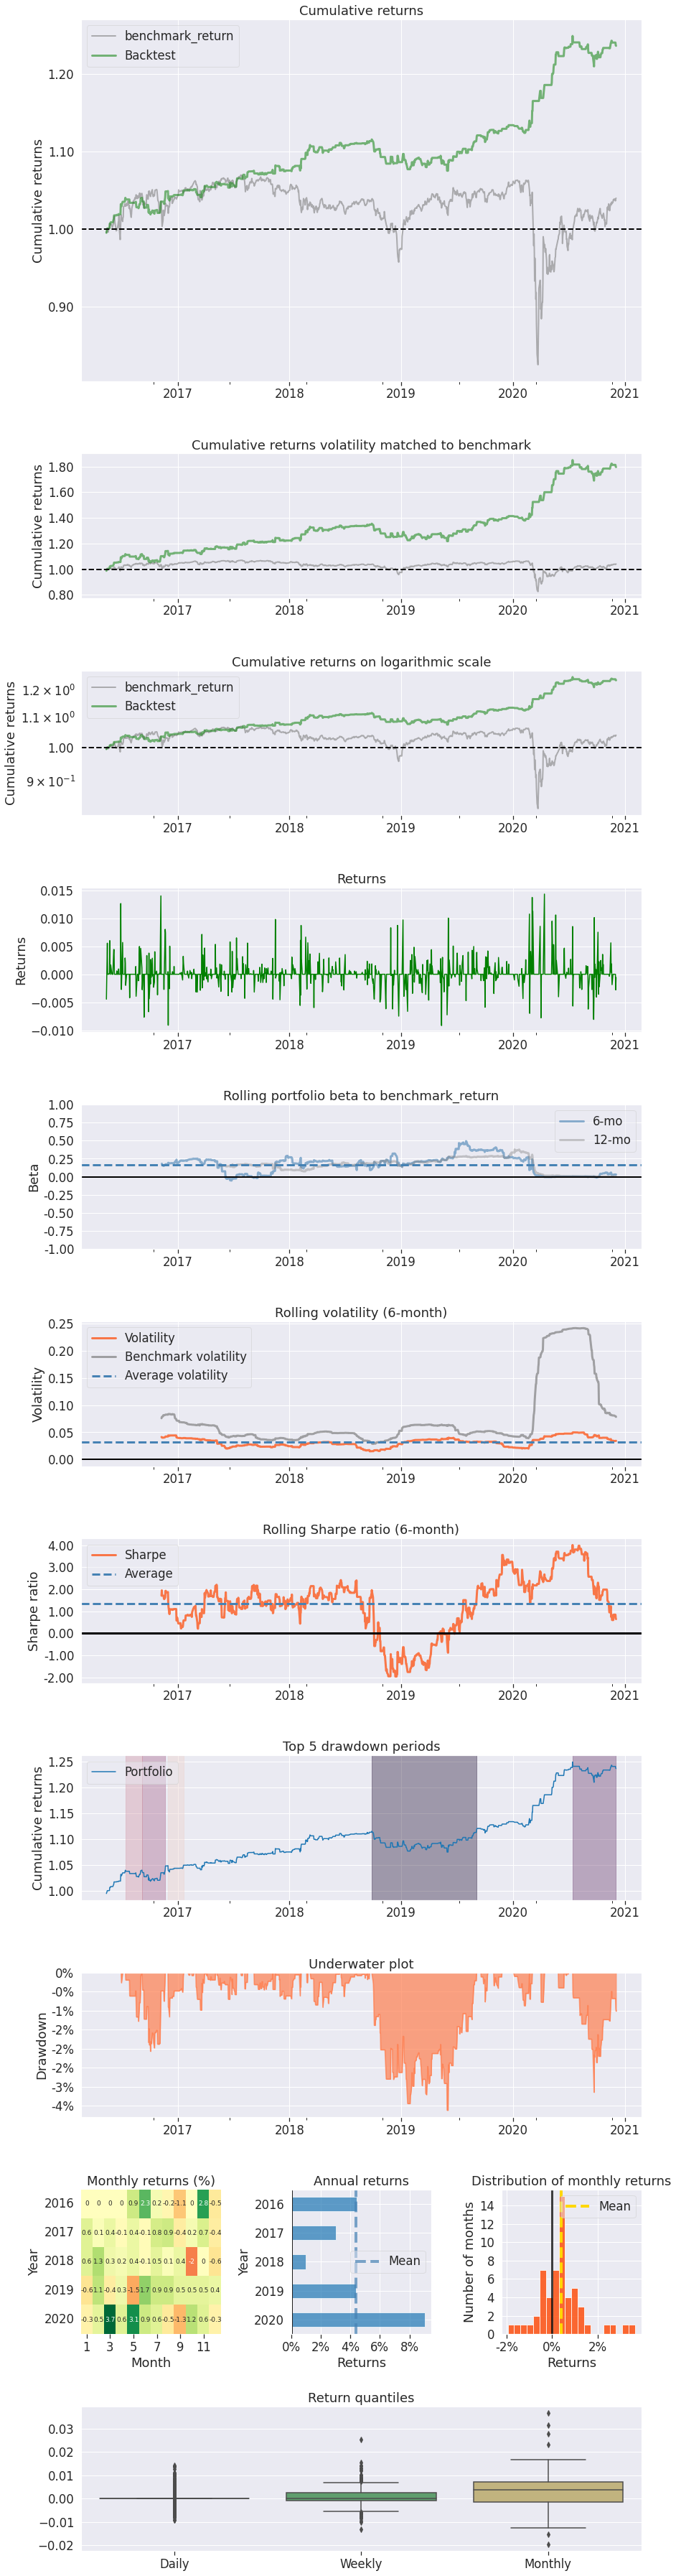

In [ ]:
pb.plot_evaluation(topic, index, time_horizon, aggregate_method)

In [ ]:
pb.price_signal_df[pb.start_date:pb.end_date]

,Close,pred_distance_fbp,signal,position,return,benchmark_return,benchmark_return_same_period
Date,,,,,,,
2016-05-12,83.150002,0.119628,1.0,1.0,NaN,NaN,NaN
2016-05-13,82.779999,0.229798,1.0,1.0,-0.004450,-0.004450,-0.004450
2016-05-16,83.239998,NaN,0.0,0.0,0.005557,0.005557,0.005557
2016-05-17,83.070000,NaN,0.0,0.0,-0.000000,-0.002042,-0.002042
2016-05-18,83.080002,NaN,0.0,0.0,0.000000,0.000120,0.000120
...,...,...,...,...,...,...,...
2020-11-27,86.410004,NaN,0.0,0.0,0.000000,0.001623,0.001623
2020-11-30,86.320000,NaN,0.0,0.0,-0.000000,-0.001042,-0.001042
2020-12-01,86.199997,-2.337037,-1.0,-1.0,-0.000000,-0.001390,-0.001390


### Evaluate performance for holding period > 1.

For holding period > 1, we could also show distributions among multiple transactions.

In [ ]:
import seaborn as sns
sns.set()

In [ ]:
topic, index, time_horizon

('labor market', 'U.S. Issued High Yield', 'day')

In [ ]:
pb.evaluate(topic, index, time_horizon, aggregate_method)

OrderedDict([('annual_return', 0.0479),
             ('benchmark_annual_return', 0.0077),
             ('sharpe_ratio', 1.4136),
             ('benchmark_sharpe_ratio', 0.1283),
             ('max_drawdown', -0.0361),
             ('benchmark_max_drawdown', -0.2286)])

In [ ]:
plt.rcParams["figure.figsize"] = (6, 9)
fig, ax = plt.subplots(3)
fig.tight_layout(h_pad=5)

# ignore the outlier transactions with very high return
sns.distplot([data for data in pb.annual_returns if data < 5], ax=ax[0], bins=20)
ax[0].set_xlabel('annual return')
ax[0].set_title('median of annual return: '+str(round(np.median(pb.annual_returns), 4)))
ax[0].axvline(x=0, color='r', linestyle='-')
ax[0].axvline(x=np.median(pb.annual_returns), color='g', linestyle='-')
sns.distplot([data for data in pb.sharpe_ratios if data < 5], ax=ax[1], bins=20)
ax[1].set_xlabel('sharpe ratio')
ax[1].set_title('median of sharpe ratio: '+str(round(np.median(pb.sharpe_ratios), 4)))
ax[1].axvline(x=0, color='r', linestyle='-')
ax[1].axvline(x=np.median(pb.sharpe_ratios), color='g', linestyle='-')
sns.distplot([data for data in pb.max_drawdowns], ax=ax[2], bins=20)
ax[2].set_xlabel('max drawdown')
ax[2].axvline(x=np.median(pb.max_drawdowns), color='g', linestyle='-')
ax[2].axvline(x=-0.1, color='r', linestyle='-')
ax[2].set_title('median of max drawdown: '+str(round(np.median(pb.max_drawdowns), 4)))
plt.show()